In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline 

## Configuration

### Plotting styling

In [94]:
colors = {}
#Expert algos
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstcsig5'] = 'black'

colors['AEttbar'] = 'tab:blue'
colors['AElphe'] = 'tab:blue'
colors['AElayers'] = 'tab:orange'

colors['AElayer9'] = 'tab:blue'
colors['AElayer11'] = 'tab:orange'

styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstcsig5'] = '-.'
styles['AEttbar'] = '-'
styles['AElphe'] = '--'
styles['AElayers'] = '--'

styles['AElayer9'] = '-'
styles['AElayer11'] = '-'

legends = {}
legends['Threshold0'] = 'Truth'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstcsig5'] = 'Real BC+STC 5' 

legends['AEttbar'] = 'ttbar'
legends['AElphe'] = 'AE Layer 9'
legends['AElayers'] = 'AE Layers 5,7,9,11'

legends['AElayer9'] = 'AE Layer 9 sim>0'
legends['AElayer11'] = 'AE Layer 11 sim>0'

ref_name = 'Threshold0'

colors['AElell'] = 'green'
colors['AEleml'] = 'blue'
colors['AElehl'] = 'red'

styles['AElell'] = '-'
styles['AEleml'] = '-'
styles['AElehl'] = '-'

legends['AElell'] = 'Low eta, low layer'
legends['AEleml'] = 'low eta med layer'
legends['AElehl'] = 'low eta high layer'

colors['AEmell'] = 'green'
colors['AEmeml'] = 'blue'
colors['AEmehl'] = 'red'

styles['AEmell'] = ':'
styles['AEmeml'] = ':'
styles['AEmehl'] = ':'

legends['AEmell'] = 'Med eta, low layer'
legends['AEmeml'] = 'Med eta med layer'
legends['AEmehl'] = 'Med eta high layer'

colors['AEhell'] = 'green'
colors['AEheml'] = 'blue'
colors['AEhehl'] = 'red'

styles['AEhell'] = '--'
styles['AEheml'] = '--'
styles['AEhehl'] = '--'

legends['AEhell'] = 'High eta low layer'
legends['AEheml'] = 'High eta med layer'
legends['AEhehl'] = 'High eta high layer'

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [81]:
version = 'hackathon_plots_all_eta_comp'

fig_dir = '/home/cms.rshenoy/Plots/{}'.format(version)

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [83]:
algo_files = {}

# Read  old FE set
directory_tele = '/home/cms.rshenoy/09_26_22_tele/electron_photon_signaldriven/v_1_2022-09-27'
directory_emd = '/home/cms.rshenoy/09_03_22_updates/electron_photon_signaldriven/v_1_2022-09-03'

directory_1 = '/home/cms.rshenoy/10_10_22/electron_photon_signaldriven/v_1_2022-10-11'
#sim only training
directory_2 = '/home/cms.rshenoy/10_13_22/electron_photon_signaldriven/v_1_2022-10-14'
#PU_studies
directory_3 = '/home/cms.rshenoy/10_17_22_low_eta/electron_photon_signaldriven/v_1_2022-10-19'
directory_4 = '/home/cms.rshenoy/10_17_22_med_eta/electron_photon_signaldriven/v_1_2022-10-19'
directory_5 = '/home/cms.rshenoy/10_17_22_high_eta/electron_photon_signaldriven/v_1_2022-10-19'


fes = ['Mixedbcstcsig5','AElell','AEleml','AElehl','AEmell','AEmeml','AEmehl','AEhell','AEheml','AEhehl']

for fe in fes:
    if fe == 'AElphe' or fe== 'Mixedbcstcsig5' or fe== 'AElayers':
        algo_files[fe] = (glob(directory_1+'/electrons/*.hdf5'), glob(directory_1+'/photons/*.hdf5'))
    elif fe == 'AElell'or fe=='AEleml'or fe=='AElehl':
        algo_files[fe] = (glob(directory_3+'/electrons/*.hdf5'), glob(directory_3+'/photons/*.hdf5'))
    elif fe == 'AEmell'or fe=='AEmeml'or fe=='AEmehl':
        algo_files[fe] = (glob(directory_4+'/electrons/*.hdf5'), glob(directory_4+'/photons/*.hdf5'))
    elif fe == 'AEhell'or fe=='AEheml'or fe=='AEhehl':
        algo_files[fe] = (glob(directory_5+'/electrons/*.hdf5'), glob(directory_5+'/photons/*.hdf5'))


## Loading and preprocessing dataframes

In [84]:
#load electrons and photons

algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [85]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [86]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [87]:
layer_coeffs = {}
for name,df in algo_cut.items():
    print(name)
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

Mixedbcstcsig5
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.2527e+05, final cost 1.1596e+05, first-order optimality 8.06e-09.
[1.75620018 0.95193648 1.06386141 1.0647204  1.02680519 1.21627693
 1.12529791 1.06577263 1.04472168 0.94182775 1.18862268 2.
 2.        ]
AElell
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 2.0690e+05, final cost 1.9922e+05, first-order optimality 1.12e-08.
[1.63125565 1.10471117 1.11427023 1.16879845 1.06535991 1.17071659
 1.15100177 1.10492835 1.00219466 1.00854015 1.30030936 2.
 2.        ]
AEleml
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.5525e+05, final cost 1.4736e+05, first-order optimality 2.11e-08.
[1.60226701 1.00168649 1.07094791 1.07959791 1.02843014 1.11423204
 1.10377132 1.04106803 0.96613153 0.86217577 1.16983922 2.
 2.        ]
AElehl
The relative change of the cost function is less 

Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [88]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

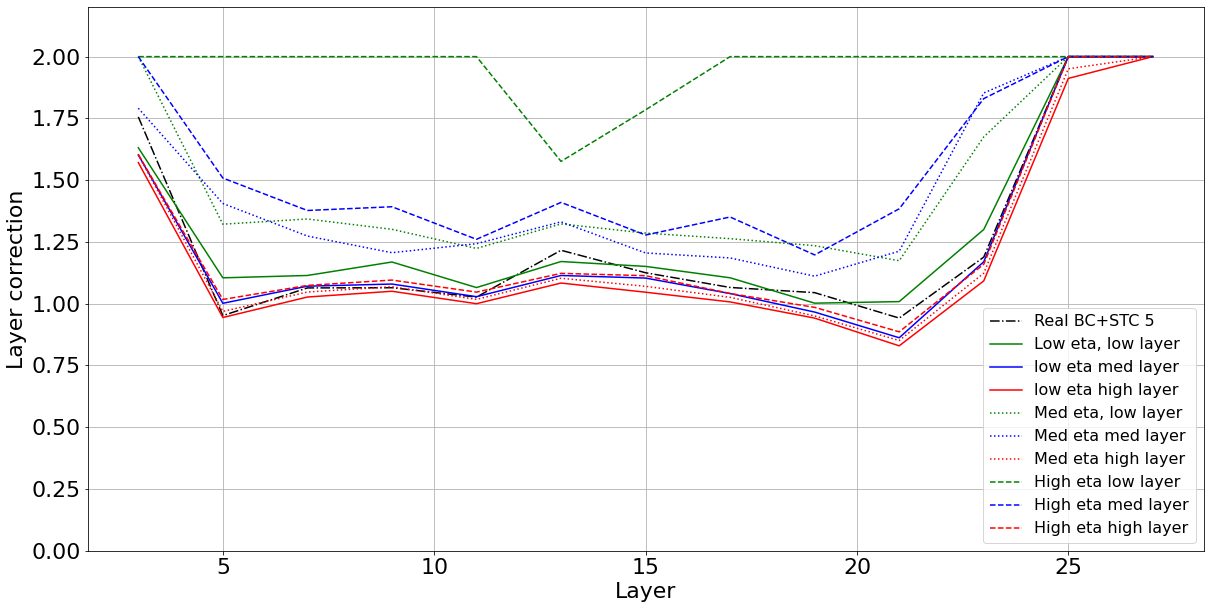

In [95]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.savefig(fig_dir+'/layer_corrections.png')
plt.show()

Check impact of layer corrections on the energy ratio distributions

Raw mean=0.9149302840232849, rms=0.036418765783309937, rms/mean=0.039804961532354355
Calib mean=1.0024377000503617, rms=0.04283149026778187, rms/mean=0.04272733384391873


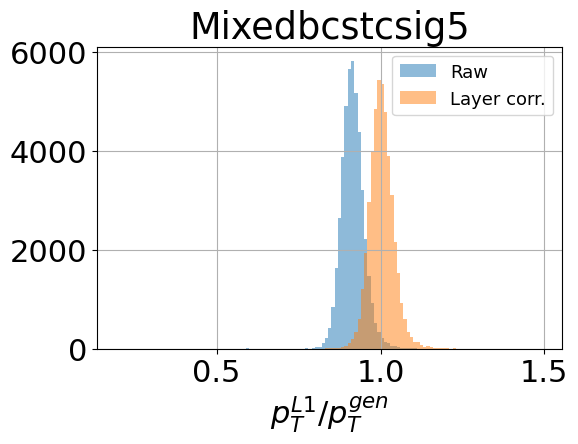

Raw mean=0.877185046672821, rms=0.04465258866548538, rms/mean=0.05090441182255745
Calib mean=0.9952361064435243, rms=0.0531613610144751, rms/mean=0.05341582833489351


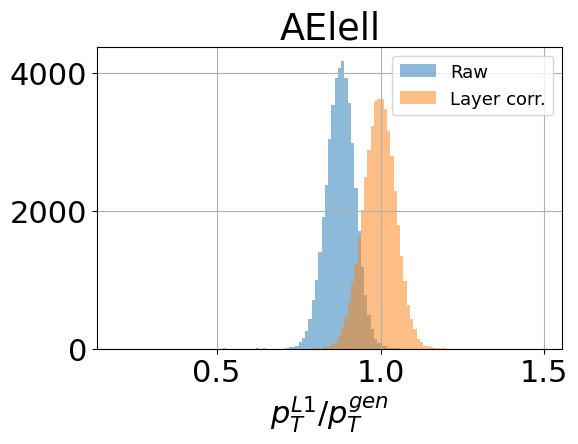

Raw mean=0.9265947341918945, rms=0.040770623832941055, rms/mean=0.04400049149990082
Calib mean=0.9953012769752488, rms=0.04673018747889246, rms/mean=0.04695079626633951


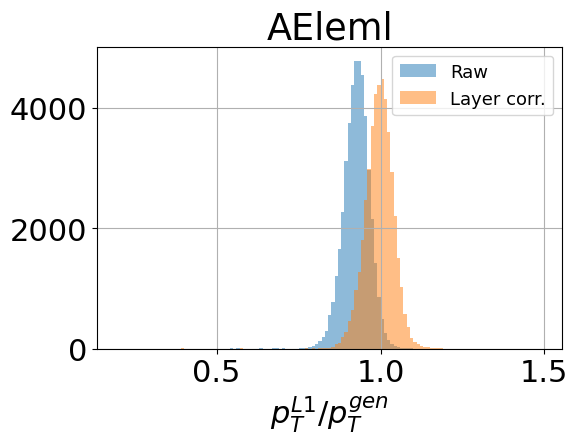

Raw mean=0.9603366851806641, rms=0.036966919898986816, rms/mean=0.03849370777606964
Calib mean=0.9957597590797435, rms=0.04165472146689321, rms/mean=0.04183209964759921


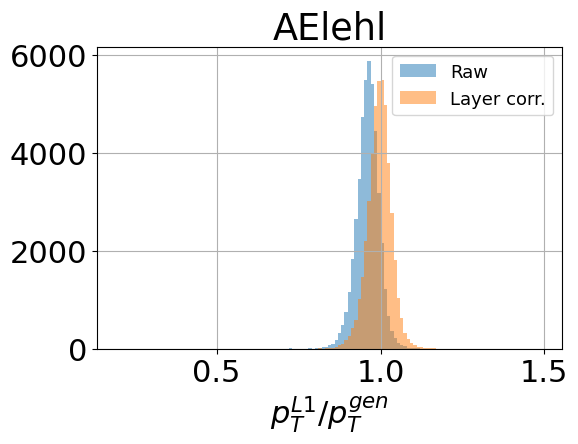

Raw mean=0.7648240923881531, rms=0.052490681409835815, rms/mean=0.06863105297088623
Calib mean=0.9957107754431013, rms=0.07007893316374782, rms/mean=0.0703808122720797


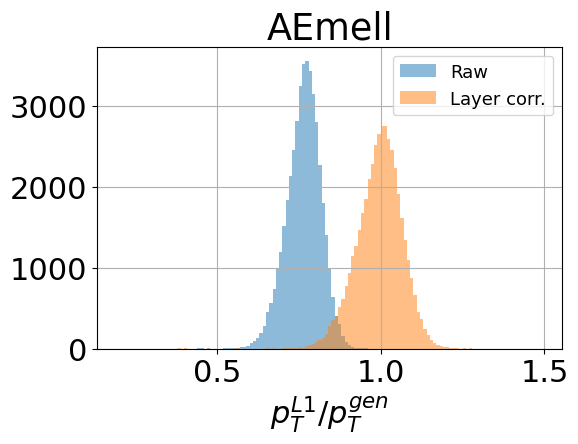

Raw mean=0.7830606698989868, rms=0.06095030903816223, rms/mean=0.07783599942922592
Calib mean=0.9925283745277431, rms=0.07877710252740197, rms/mean=0.07937012638543967


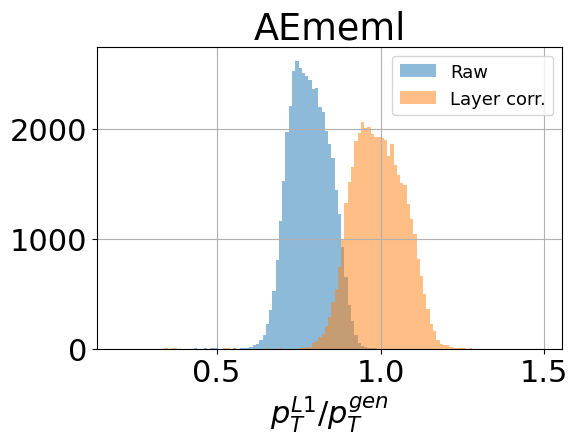

Raw mean=0.9424110054969788, rms=0.03664546087384224, rms/mean=0.03888479620218277
Calib mean=0.9955615872522584, rms=0.041975245213862644, rms/mean=0.042162379255425035


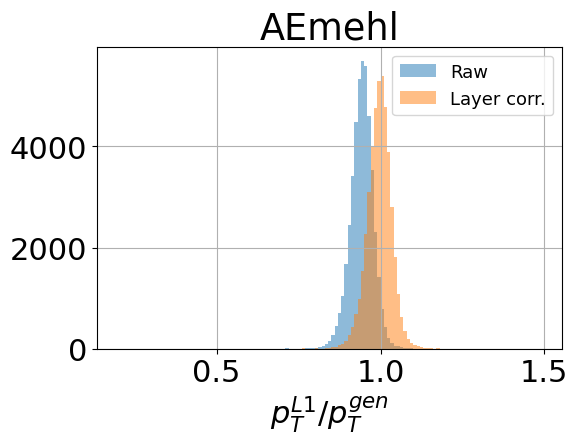

Raw mean=0.5216467380523682, rms=0.06453435122966766, rms/mean=0.12371274828910828
Calib mean=0.98793212929778, rms=0.12281109443328626, rms/mean=0.12431126672697661


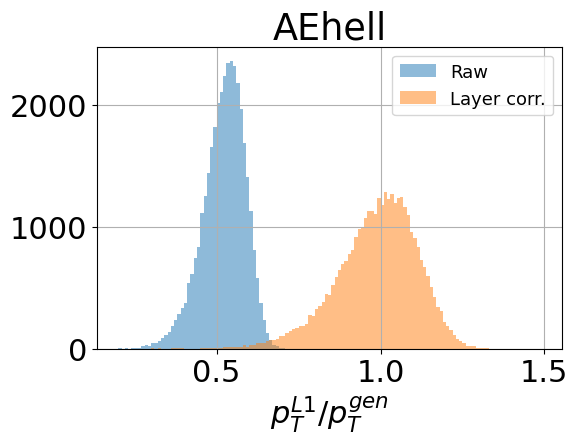

Raw mean=0.7300267219543457, rms=0.05513888597488403, rms/mean=0.07552995532751083
Calib mean=0.995423022663275, rms=0.07662018169229157, rms/mean=0.07697248300254567


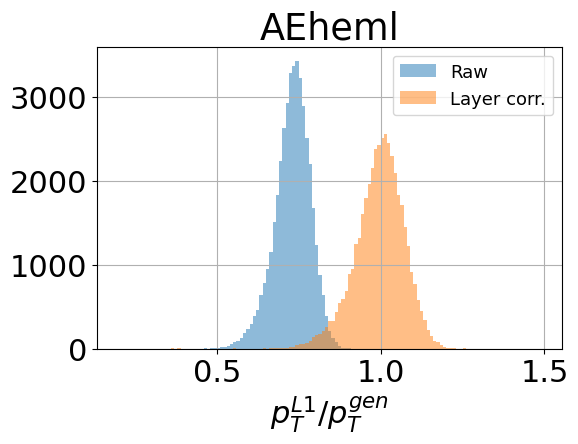

Raw mean=0.9171973466873169, rms=0.037474341690540314, rms/mean=0.04085744544863701
Calib mean=0.995387423262805, rms=0.043679482089850556, rms/mean=0.04388189067797592


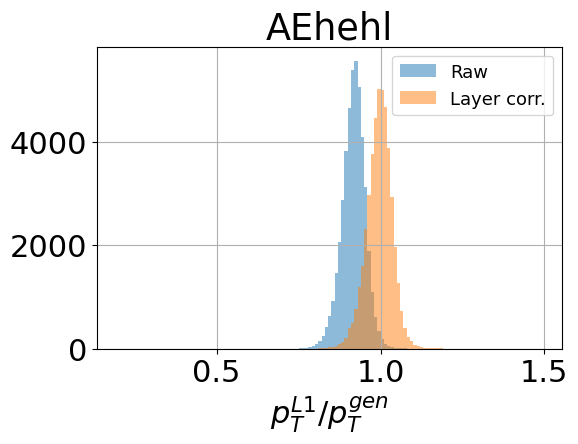

In [96]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.savefig(fig_dir+'/energy_ratio_'+name+'.png')
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [97]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  Mixedbcstcsig5
  AElell
  AEleml
  AElehl
  AEmell
  AEmeml
  AEmehl
  AEhell
  AEheml
  AEhehl


Print correction value at eta=1.5 and eta=3

In [98]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

Mixedbcstcsig5
  eta=1.5: [5.1572704]
  eta=3: [-4.955901]
AElell
  eta=1.5: [5.4153805]
  eta=3: [-18.570364]
AEleml
  eta=1.5: [5.1924305]
  eta=3: [-18.195755]
AElehl
  eta=1.5: [4.8556957]
  eta=3: [-15.660845]
AEmell
  eta=1.5: [6.0902557]
  eta=3: [-19.341122]
AEmeml
  eta=1.5: [5.5759373]
  eta=3: [-19.435839]
AEmehl
  eta=1.5: [4.868534]
  eta=3: [-15.804016]
AEhell
  eta=1.5: [9.590115]
  eta=3: [-21.078018]
AEheml
  eta=1.5: [6.1449165]
  eta=3: [-19.226698]
AEhehl
  eta=1.5: [5.019663]
  eta=3: [-16.868456]


In [99]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt']    

Raw mean=0.9334275722503662, rms=0.1265707015991211, rms/mean=0.13559778034687042
Calib mean=0.9986603508635336, rms=0.10992575018247226, rms/mean=0.11007320966274504
Corr eta mean=1.0024019770198898, rms=0.08594799420431988, rms/mean=0.0857420437855087


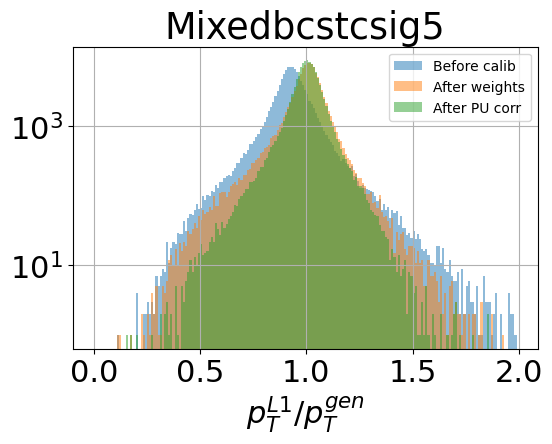

Raw mean=1.023564100265503, rms=0.20798259973526, rms/mean=0.2031944990158081
Calib mean=1.1500783674163466, rms=0.2058626607335828, rms/mean=0.17899881135583282
Corr eta mean=0.9847974842601939, rms=0.11441465840575708, rms/mean=0.11618090037233231


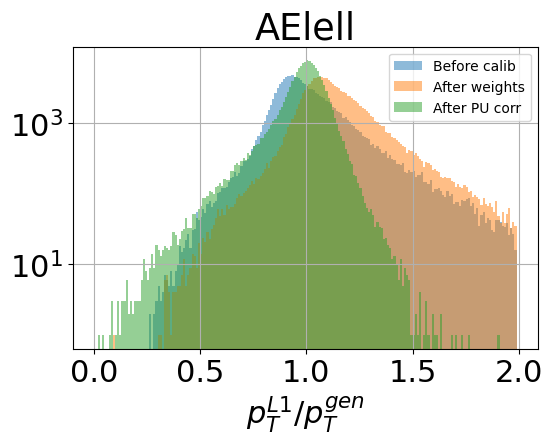

Raw mean=1.0771483182907104, rms=0.2121773362159729, rms/mean=0.19698061048984528
Calib mean=1.1470326925978118, rms=0.20026392540000612, rms/mean=0.17459304054049782
Corr eta mean=0.9837215469958321, rms=0.1146005774080999, rms/mean=0.11649696782395012


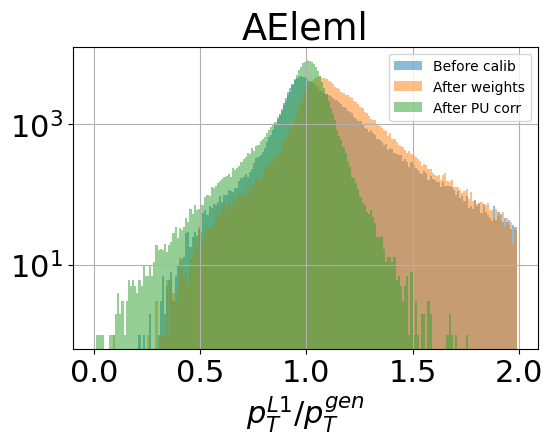

Raw mean=1.0887526273727417, rms=0.1909848302602768, rms/mean=0.17541618645191193
Calib mean=1.1179361997698058, rms=0.17129555413619912, rms/mean=0.1532248031430332
Corr eta mean=0.9825493571687904, rms=0.11474168720476138, rms/mean=0.11677956569570083


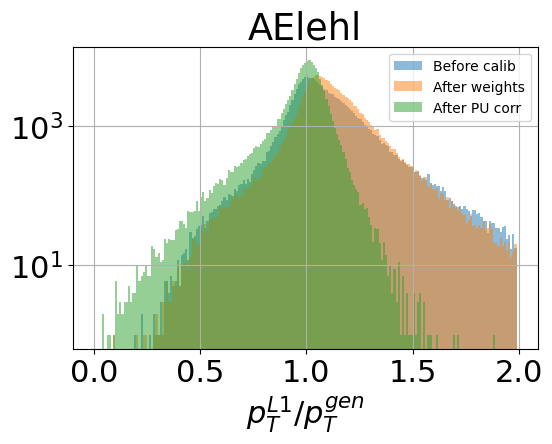

Raw mean=0.8876876831054688, rms=0.19216226041316986, rms/mean=0.21647508442401886
Calib mean=1.1535136036716251, rms=0.21852151358489272, rms/mean=0.18943991027876947
Corr eta mean=0.9885443492232966, rms=0.12010880943413095, rms/mean=0.12150067877935972


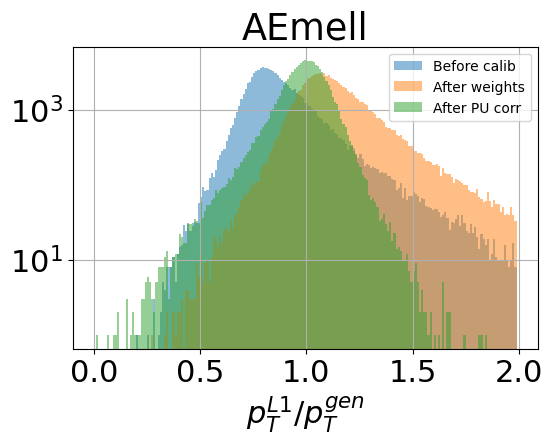

Raw mean=0.9180359840393066, rms=0.19684113562107086, rms/mean=0.21441549062728882
Calib mean=1.1601129371902967, rms=0.218183858190804, rms/mean=0.18807122237532176
Corr eta mean=0.9856502675569871, rms=0.12236863759336922, rms/mean=0.12415015916007374


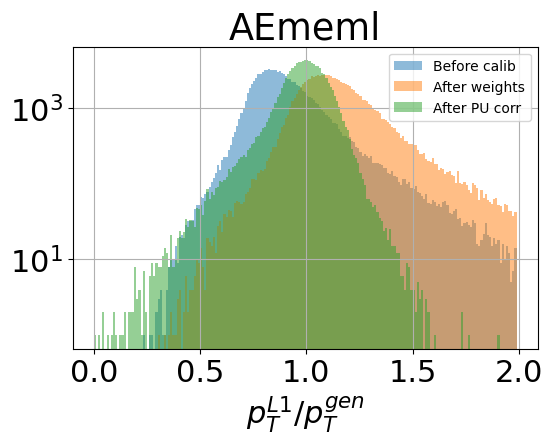

Raw mean=1.0708576440811157, rms=0.19097964465618134, rms/mean=0.17834270000457764
Calib mean=1.1209002224249298, rms=0.17448465997221874, rms/mean=0.15566475631055066
Corr eta mean=0.9836719952350106, rms=0.10949074239105037, rms/mean=0.11130818293235213


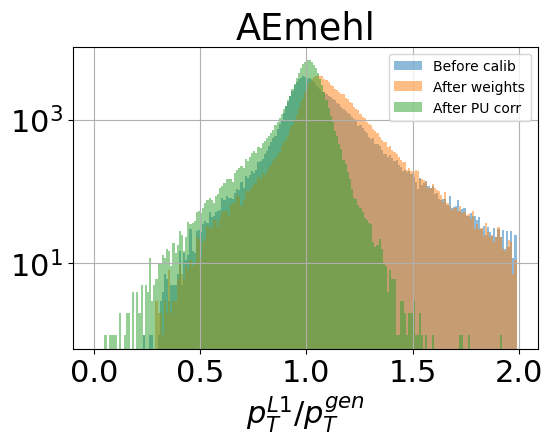

Raw mean=0.6034236550331116, rms=0.15831735730171204, rms/mean=0.2623651921749115
Calib mean=1.1148661428967561, rms=0.25087542724044154, rms/mean=0.22502739798752167
Corr eta mean=1.0013131243894513, rms=0.1571700017950183, rms/mean=0.15696388868452354


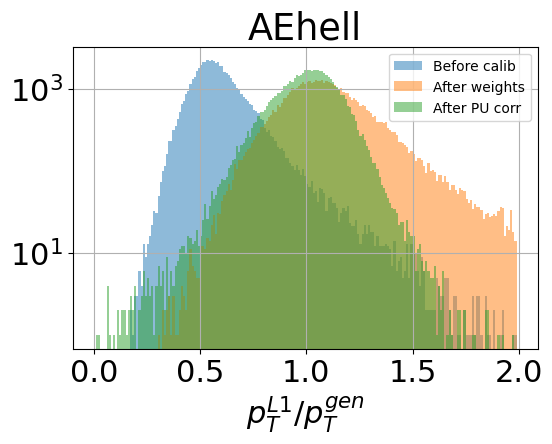

Raw mean=0.8424509763717651, rms=0.18438445031642914, rms/mean=0.21886667609214783
Calib mean=1.1491571803380016, rms=0.21966133190896273, rms/mean=0.19114994507918728
Corr eta mean=0.9898709186977999, rms=0.12484763427275257, rms/mean=0.12612516633683185


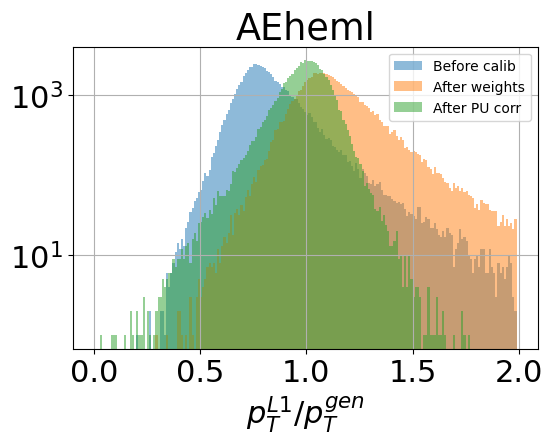

Raw mean=1.0530904531478882, rms=0.19558732211589813, rms/mean=0.18572698533535004
Calib mean=1.1312121625570375, rms=0.1835181712921724, rms/mean=0.16223143400203596
Corr eta mean=0.9837601257791194, rms=0.10990692350193904, rms/mean=0.11172126275690919


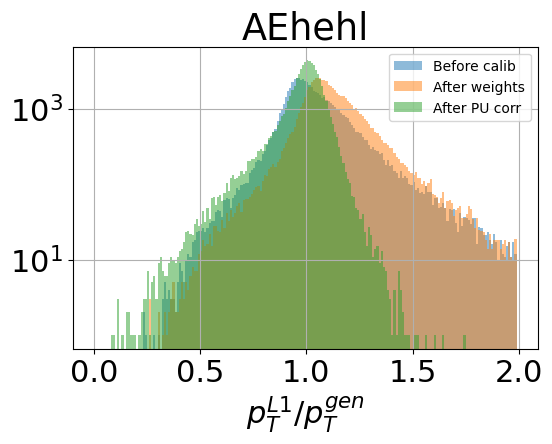

In [100]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.savefig(fig_dir+'/eta_corrections'+name+'.png')
    plt.show()

## Final plots
### For electrons with 200PU, looking at $p_T > 10\,GeV, |\eta| \in all$
First bin in eta and pT

In [106]:
binetasize = 0.1
binptsize = 5
for name, df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = (
        (df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [107]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [108]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {}
both_means={}
both_eff_rms={}
both_full_rms={}
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']


for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    both_means[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).mean()
    both_eff_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).apply(effrms)
    both_full_rms[name]=select[plot_var].groupby(['genpart_binpt','genpart_bineta']).std()

In [109]:
plotted_algo = ['Mixedbcstcsig5','AElell','AEleml','AElehl','AEmell','AEmeml','AEmehl','AEhell','AEheml','AEhehl']

Mean vs eta


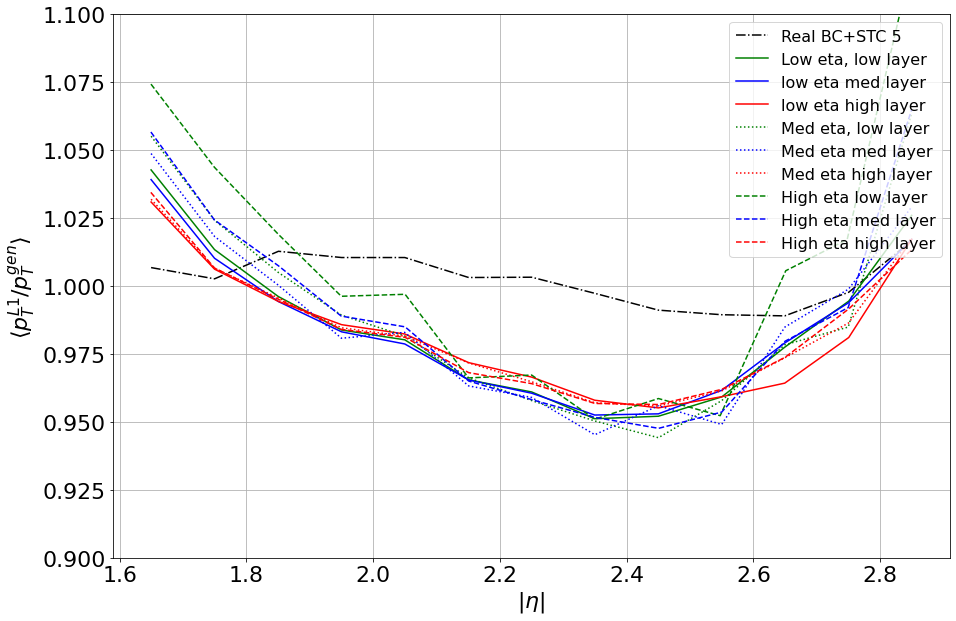

RMS vs eta


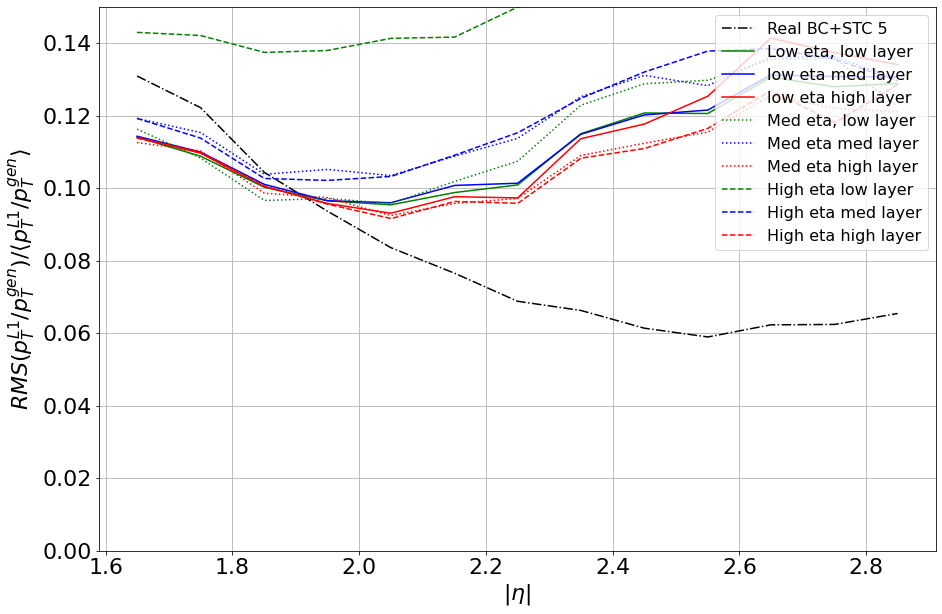

Eff RMS vs eta


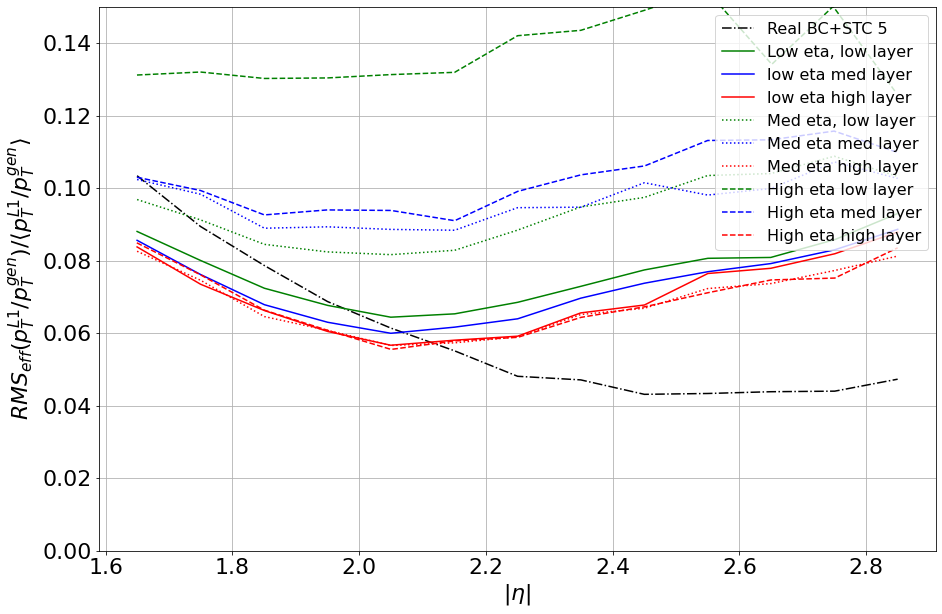

Mean vs pt


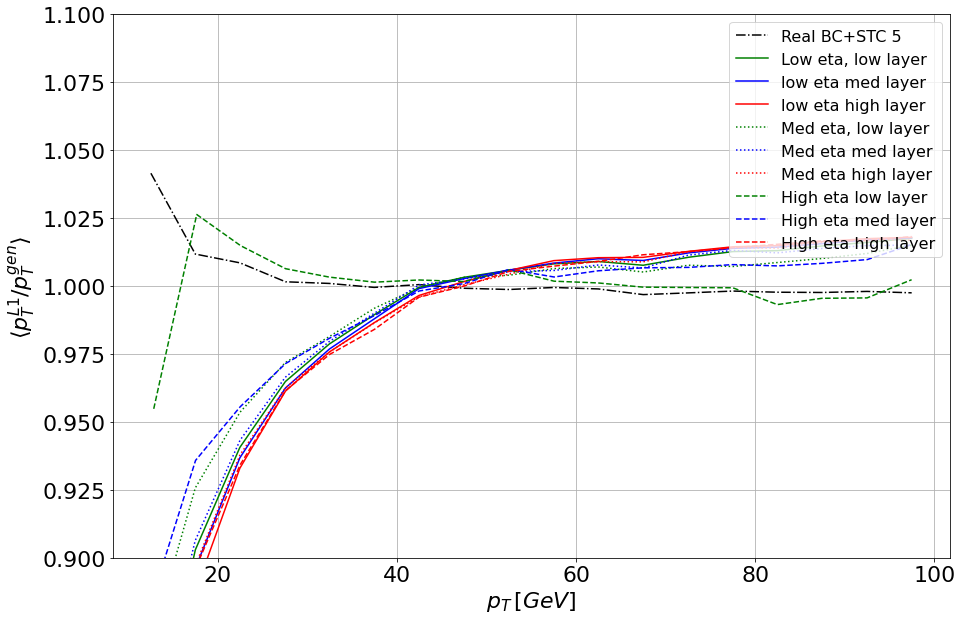

RMS vs pt


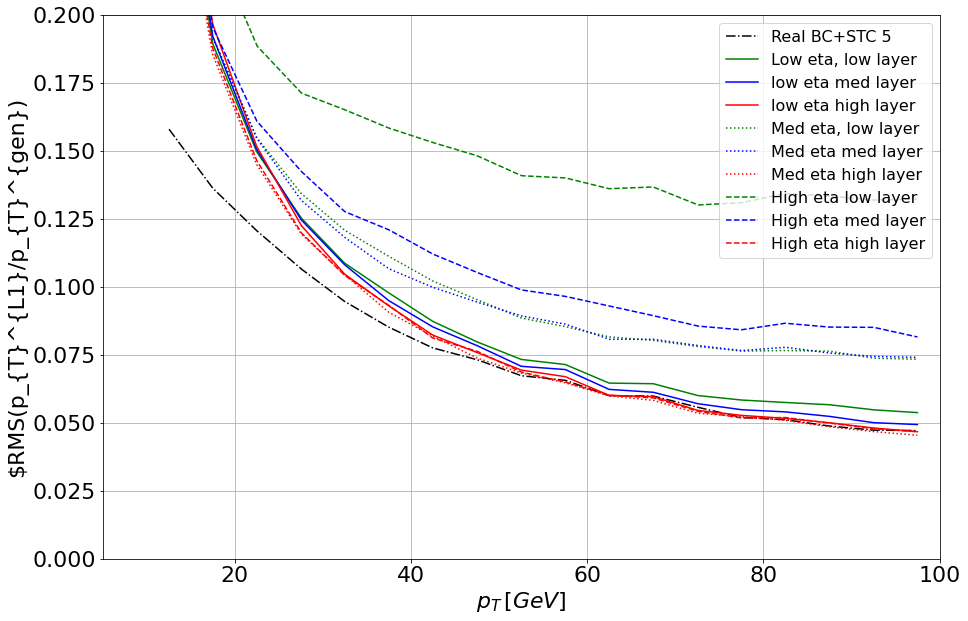

Eff RMS vs pt


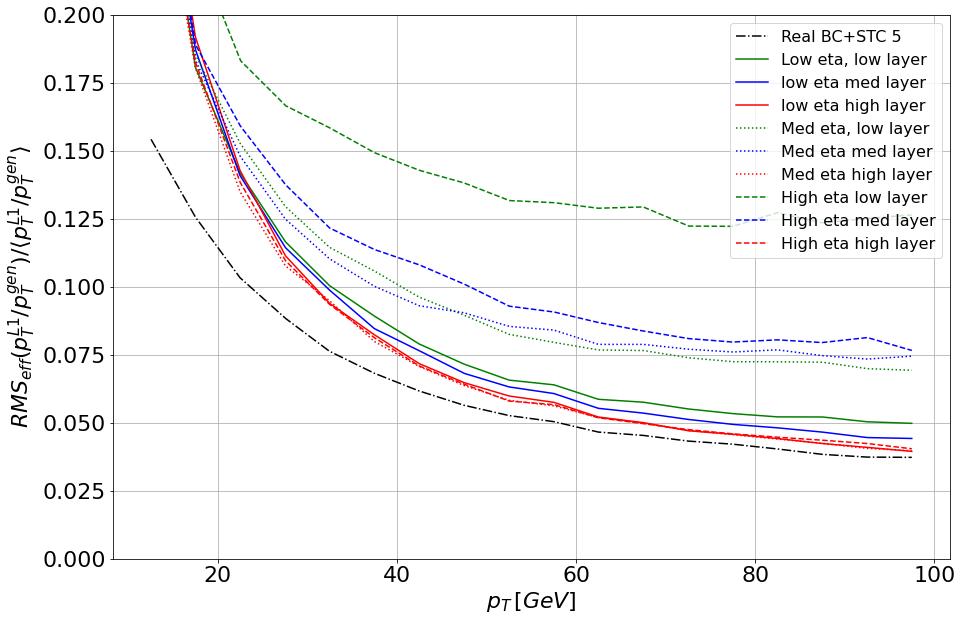

In [110]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/mean_v_eta.png')
plt.show()


print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_v_eta.png')
plt.show()


print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_eta.png')
plt.show()


print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/mean_v_eta.png')
plt.show()


print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen})')
plt.grid()
plt.savefig(fig_dir+'rms_v_pT.png')
plt.show()


print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/rms_eff_v_pT.png')
plt.show()

RMS vs pt


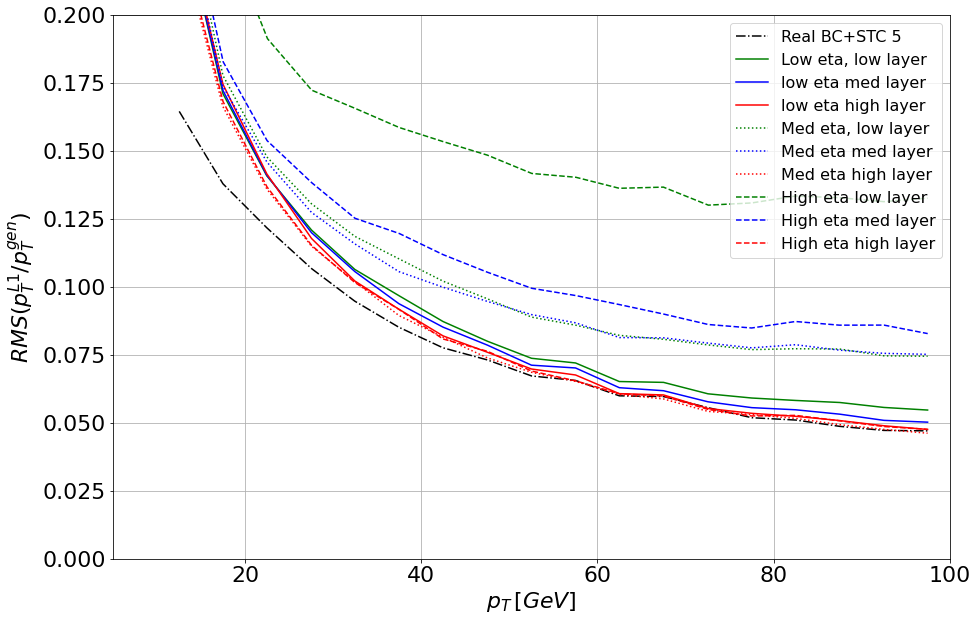

In [111]:
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen})$')
plt.grid()
plt.savefig(fig_dir+'/rms_v_pT.png')
plt.show()

Eff RMS vs eta


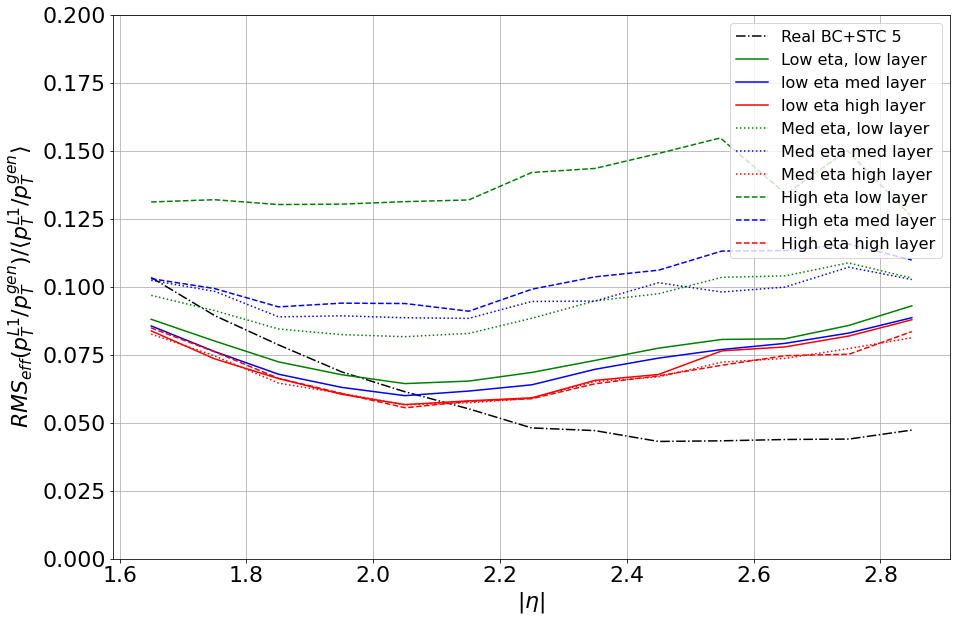

In [112]:
plt.close()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.20)
#plt.axhline(y=0.,color='g',label = 'Ideal', linewidth = 5)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.savefig(fig_dir+'/hack.png',dpi=400)

### For electrons with 200PU, looking at $p_T > 10\,GeV, |\eta| < 2.0$


In [113]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10 and abs(genpart_abseta)<2')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs eta


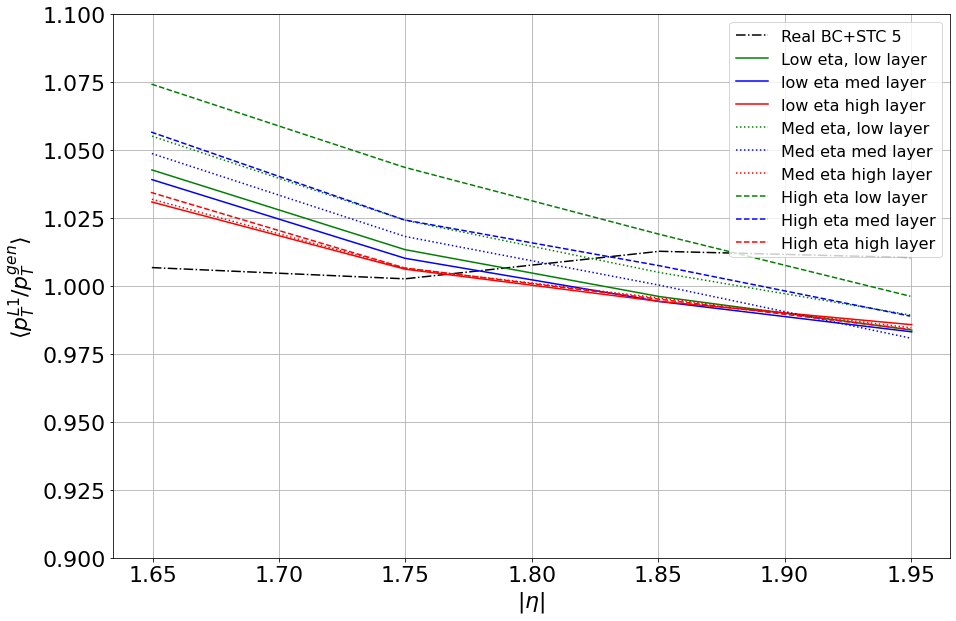

RMS vs eta


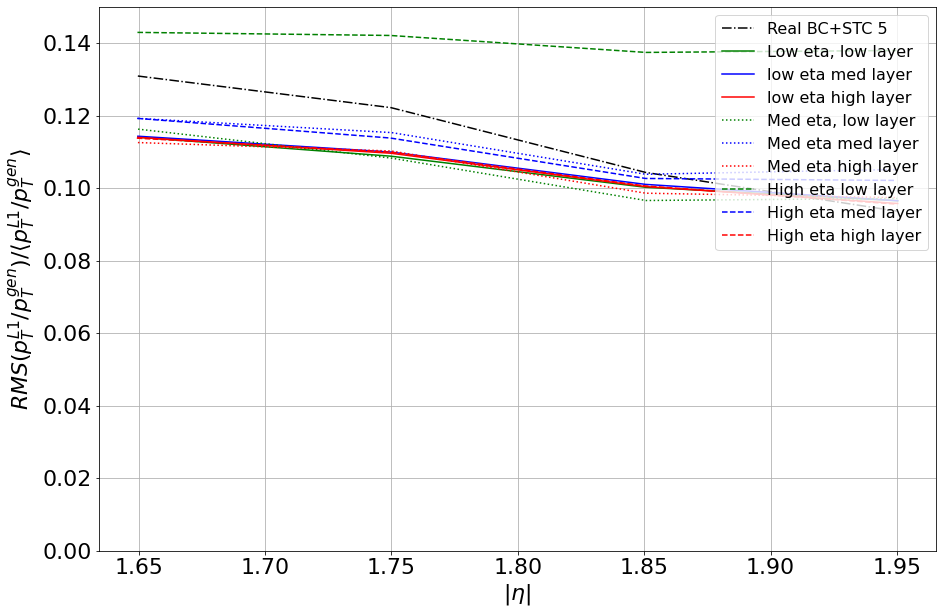

Eff RMS vs eta


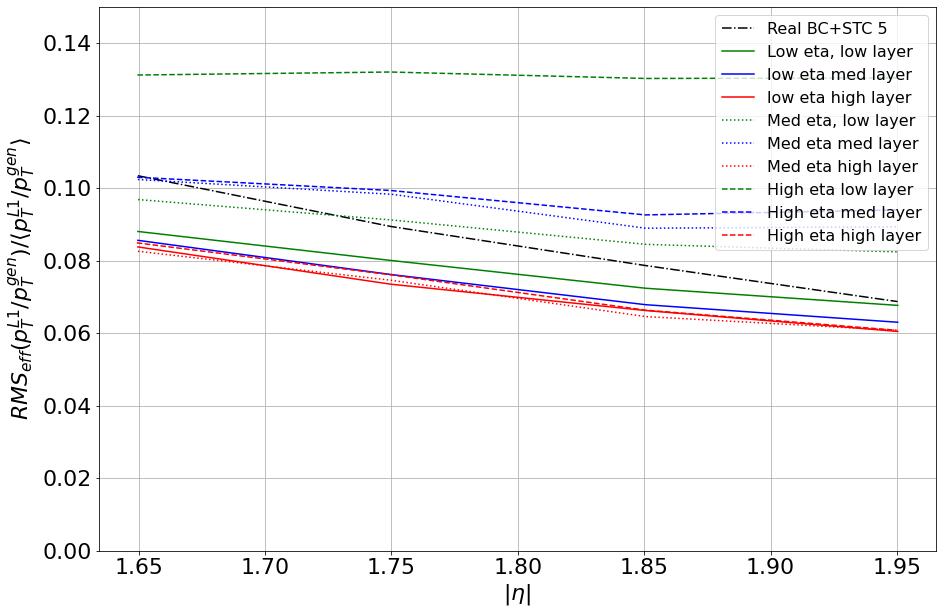

In [114]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

Mean vs pt


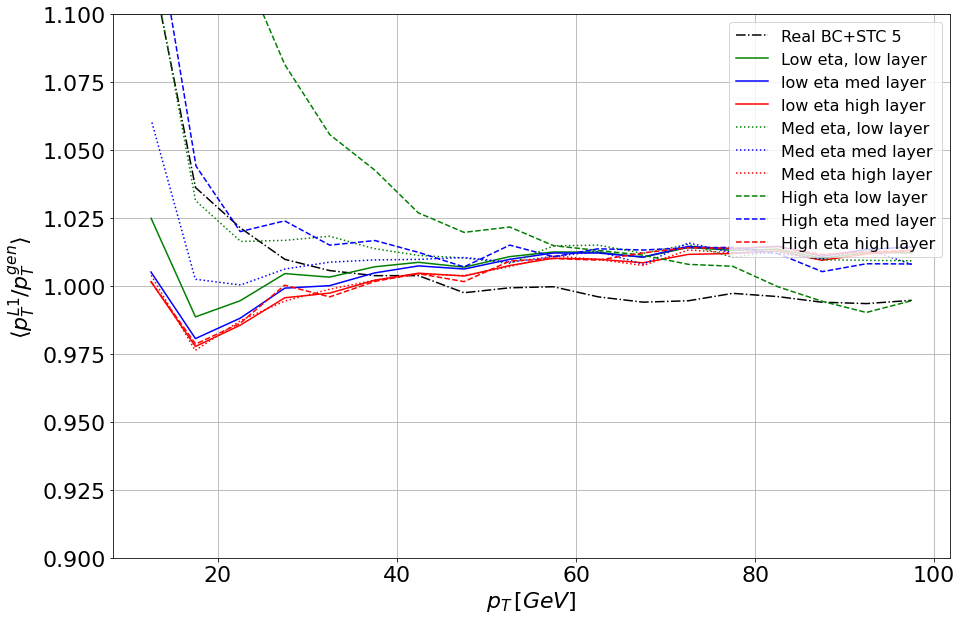

RMS vs pt


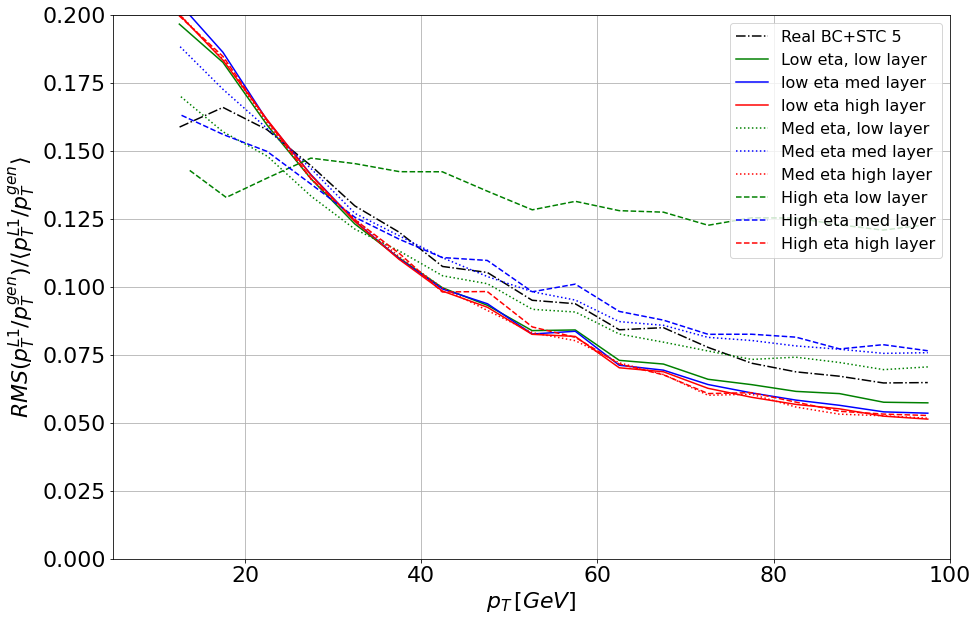

Eff RMS vs pt


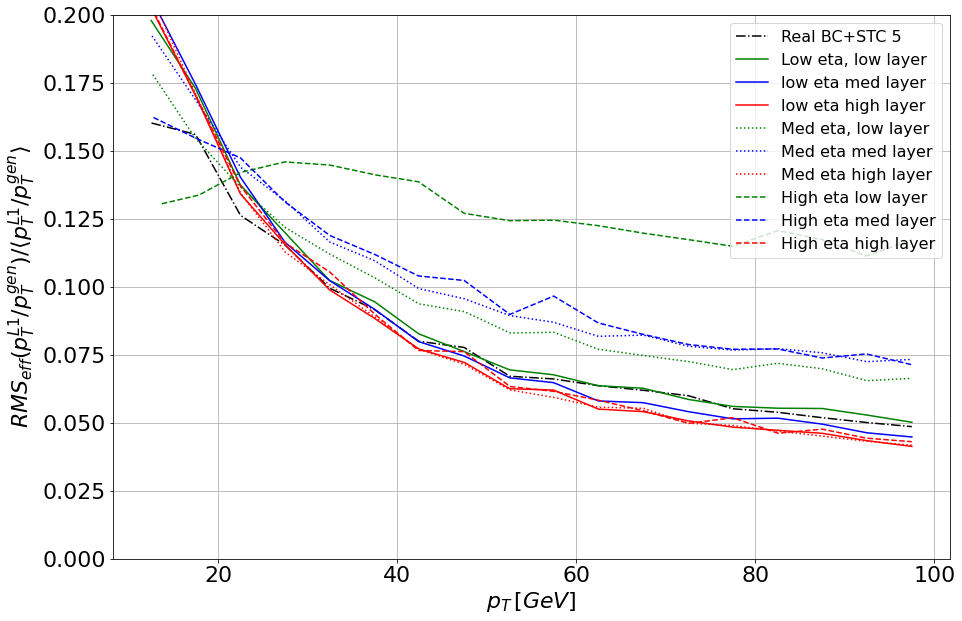

In [115]:
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

### For electrons with 200PU, looking at $p_T > 10\,GeV, |\eta| \in [2.0,2.4]$

In [116]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10 and abs(genpart_abseta)<2.4 and abs(genpart_abseta)>2.0')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs eta


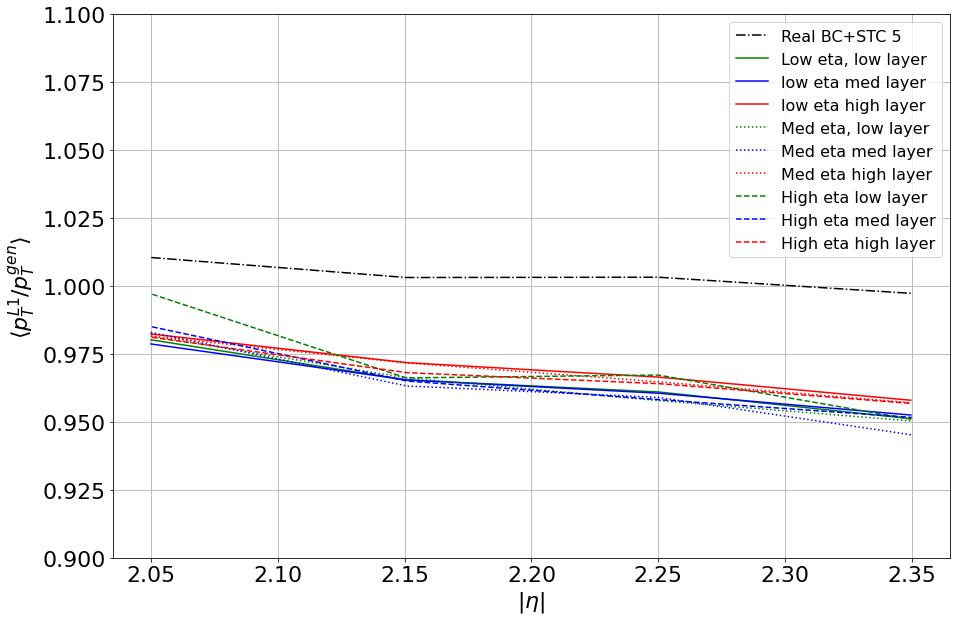

RMS vs eta


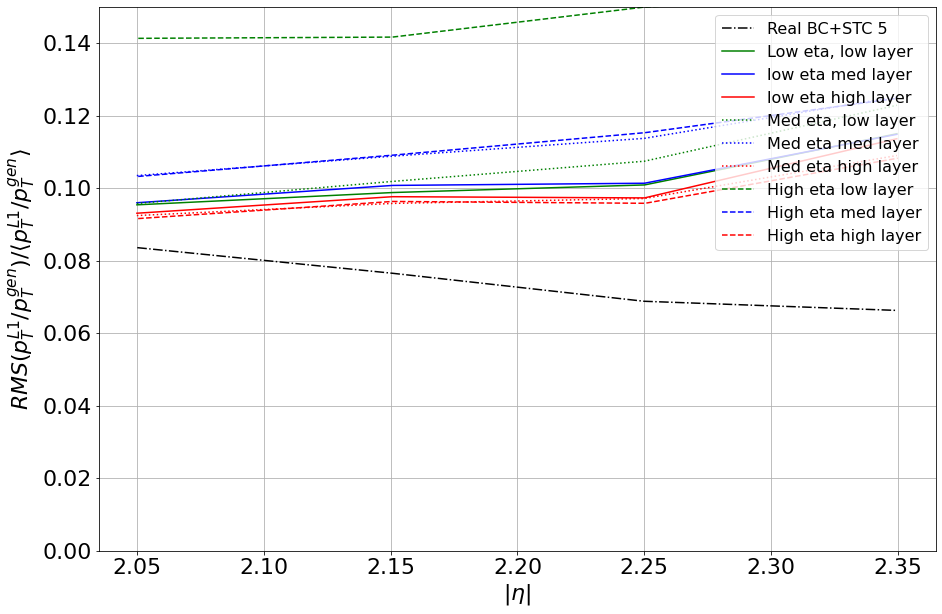

Eff RMS vs eta


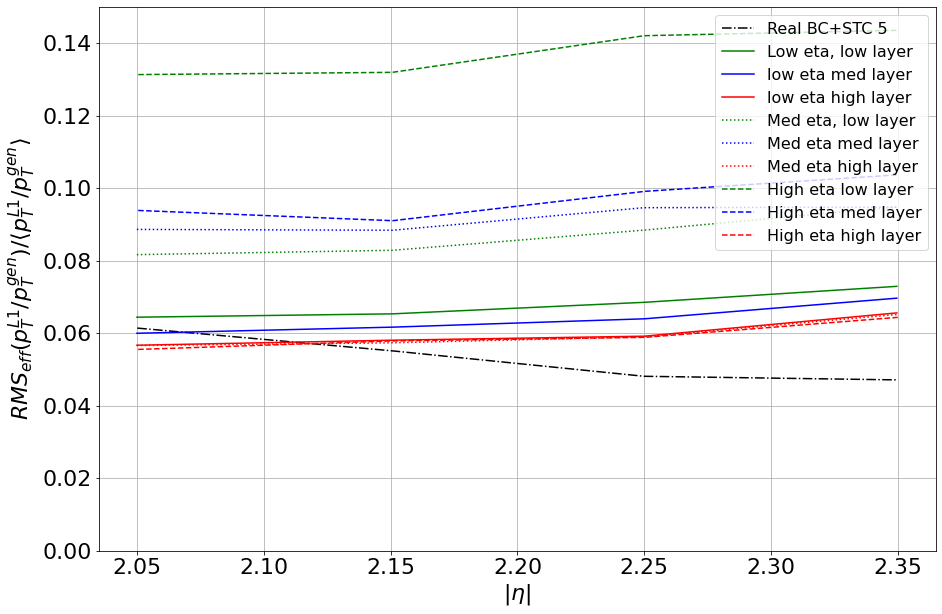

In [117]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.15)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

Mean vs pt


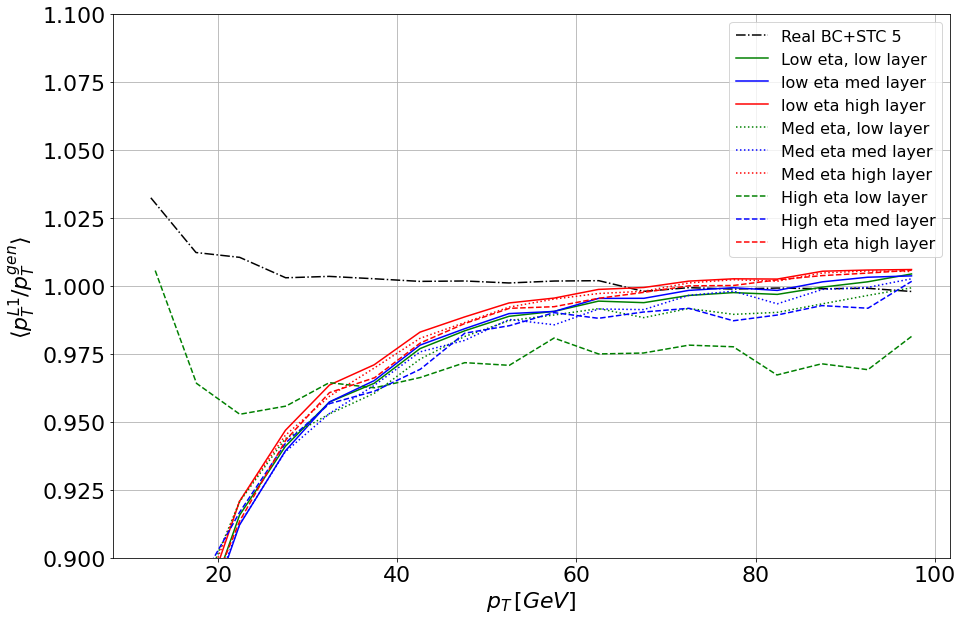

RMS vs pt


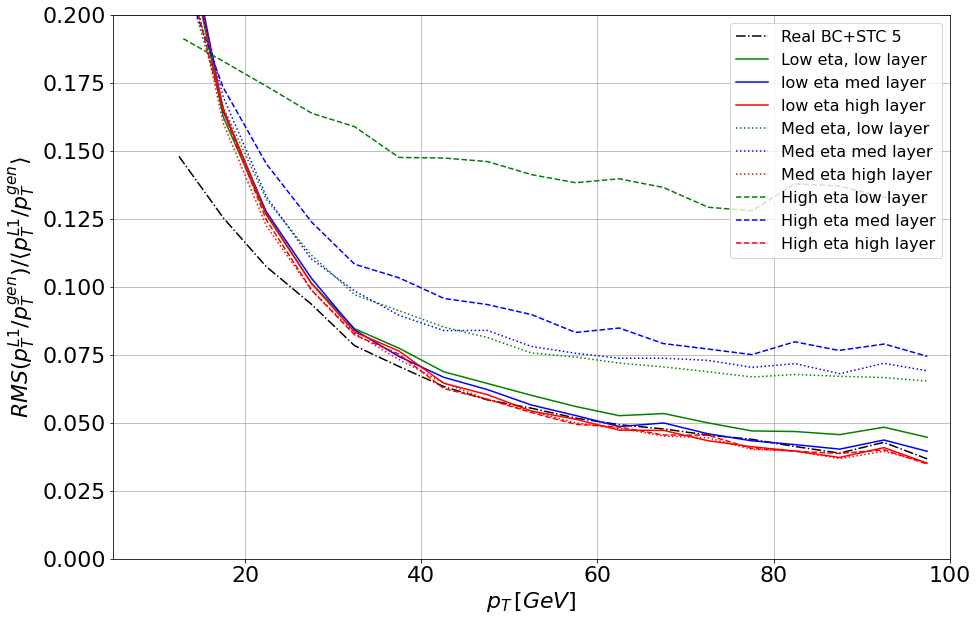

Eff RMS vs pt


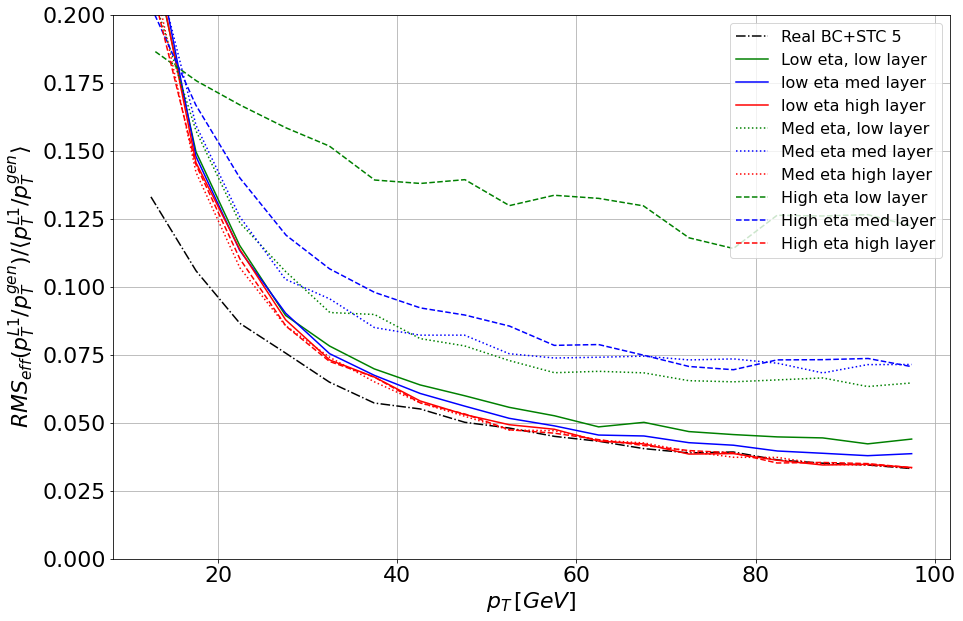

In [118]:
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

### For electrons with 200PU, looking at $p_T > 10\,GeV, |\eta| \in [2.4,2.8]$

In [119]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10 and abs(genpart_abseta)<2.8 and abs(genpart_abseta)>2.4')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs pt


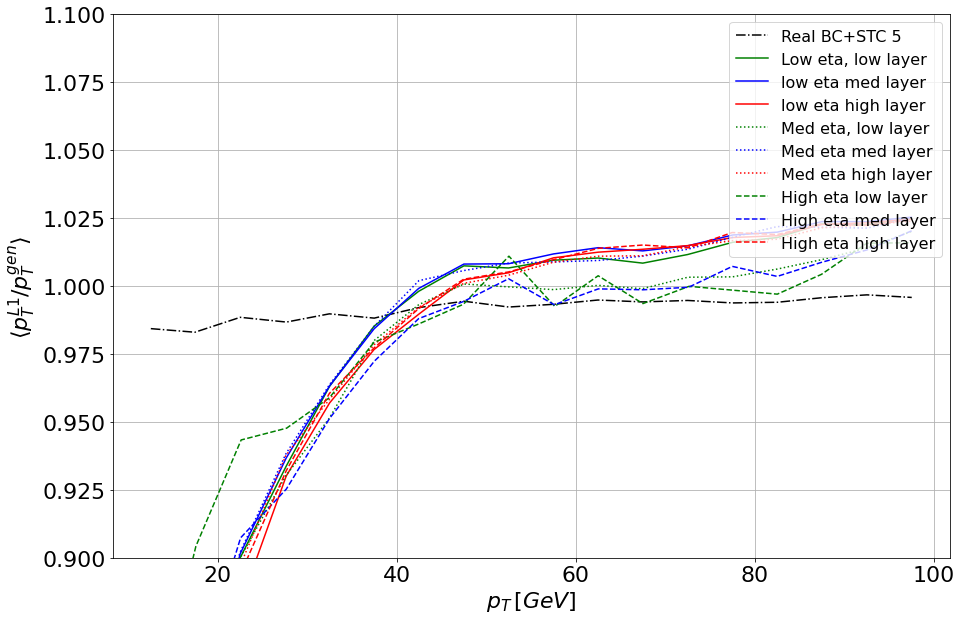

RMS vs pt


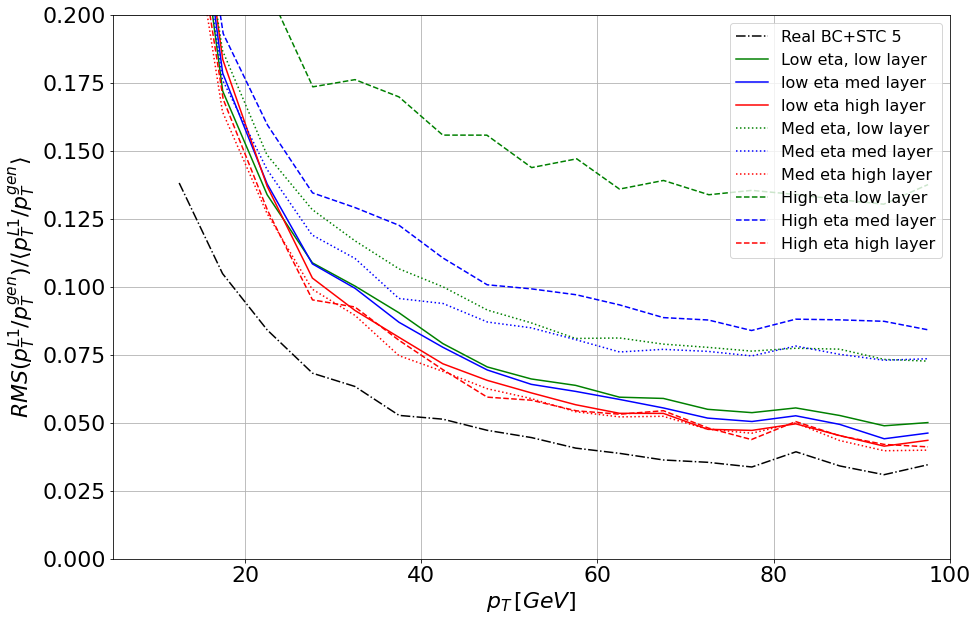

Eff RMS vs pt


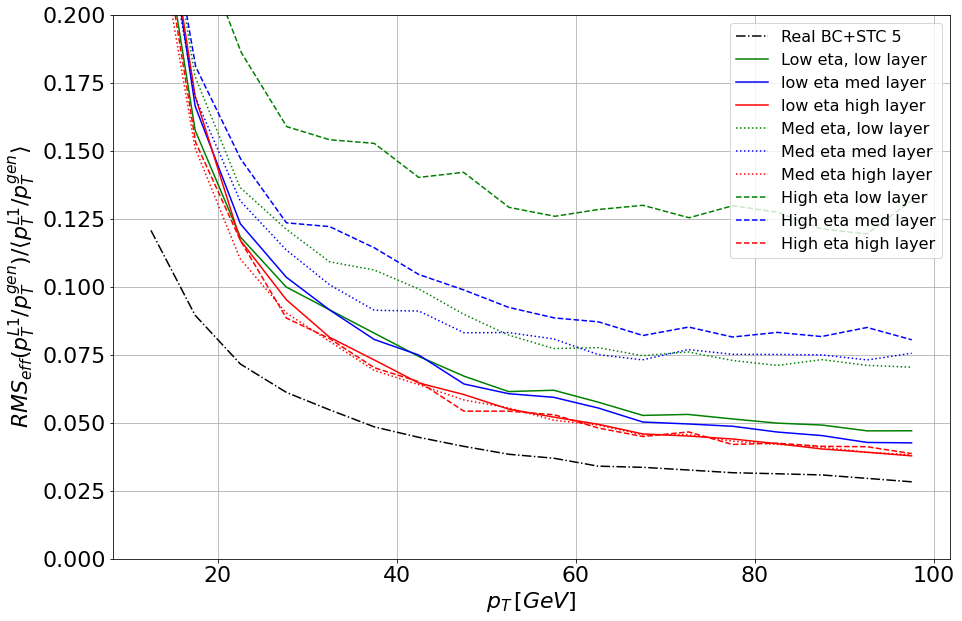

In [120]:
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

## Storing layer weights and eta corrections for external use

In [28]:
with open(fig_dir+'/layer_weights_photons_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(layer_coeffs, f)
with open(fig_dir+'/lineareta_electrons_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(corrs['eta'], f)